This is a worked example about how we could use the framework for real work
The cells are going to repeat in content, but you should think about actually 
doing it all in one cell, progressively hacking the code towards the right result

In [25]:
from databaker.framework import *
inputfile = "ott.xls"
outputfile = "ott.csv"
previewfile = "preview.html"

tabs = loadxlstabs(inputfile)


Loading ott.xls which has size 193536 bytes
Table names: ['Index', 'Table 1', 'Table 2', 'Table 3', 'Table 4', 'Table 5']


In [26]:
# throw away the tabs we don't need and maybe sort those we like into lookup dicts
tabs = list(filter((lambda tab: tab.name != "Index"), tabs))   # needs to be a list() or the generator gets consumed
dtabs = dict((tab.name, tab)  for tab in tabs)  
dtabs.keys()

dict_keys(['Table 5', 'Table 4', 'Table 1', 'Table 3', 'Table 2'])

In [27]:
# This has 5 tables, some pages of which have a lot of similarity (eg Table2=Table4)
# It is useful to work in terms of functions that we call with a table, because we can 
# easily hack which function applies to which table in a small set of code at the bottom

# Start with some processing that applies to most of the pages
def tabprocess(tab):
    yearset = tab.excel_ref("A1").fill(DOWN).is_not_blank().is_number()
    monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank()
    savepreviewhtml([yearset, monthset], previewfile)

tabprocess(dtabs["Table 3"])


tablepart 'Table 3' written #injblock1009


/home/goatchurch/sensiblecode/src/databaker/databaker/tutorial/preview.html

In [28]:
# There is a bottom panel on all of the tabs, which we will want to subtract out using this statement
#    tab.filter(contains_string("Latest three months")).expand(DOWN).expand(RIGHT) 
# It would be nice to have 5 screens to throw up all the previews on.  But we can also use code to 
# check our assumptions about the contents of these tables
for tab in tabs:
    print(tab.filter(contains_string("Latest three months")))

{<A50 'Latest three months'>}
{<A50 'Latest three months'>}
{<A50 'Latest three months'>}
{<A50 'Latest three months'>}
{<A51 'Latest three months'>}


In [29]:
# That looks pretty consistent.  We can build it into our processing
def tabprocess(tab):
    bottomblock = tab.filter(contains_string("Latest three months")).expand(DOWN).expand(RIGHT)
    yearset = tab.excel_ref("A1").fill(DOWN).is_not_blank().is_number() - bottomblock
    monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank() - bottomblock
    obs = monthset.by_index(1).fill(RIGHT).expand(DOWN) - bottomblock
    savepreviewhtml([yearset, monthset, obs], previewfile)

tabprocess(dtabs["Table 3"])


tablepart 'Table 3' written #injblock1010


/home/goatchurch/sensiblecode/src/databaker/databaker/tutorial/preview.html

In [30]:
# There's some junk on the right hand side of the table sometimes.  
# We can find it, print it, and remove it
for tab in tabs:
    cornertr = tab.regex("thousands|.*million")
    print(cornertr)
    print(cornertr.fill(RIGHT).fill(DOWN).is_not_blank())

{<Q2 'thousands'>}
set()
{<M2 'thousands'>}
{<N51 0.0>, <N48 0.0>, <N49 0.0>, <N52 0.0>, <N45 0.0>}
{<Q2 'thousands'>}
set()
{<M2 'thousands'>}
{<N51 0.0>, <N48 0.0>, <N49 0.0>, <N52 0.0>, <N45 0.0>}
{<L2 '£ million'>}
set()


In [31]:
# You can see there is nothing there but some errant 0s that got accidentally left in the sheet
# we should see what they are and set some asserts that match them so that 
# we don't make something that unintentionally filters out something later on in the day

# If one of these asserts fires, it should be easy to insert a print statement or a 
# call to savepreviewhtml() to find out what's there
for tab in tabs:
    cornertr = tab.regex("thousands|.*million")
    cornertr.assert_one()
    rightjunk = cornertr.fill(RIGHT).fill(DOWN).is_not_blank()
    assert len(rightjunk) < 10
    assert set(r.value  for r in rightjunk).issubset({0.0})  # only zeros or nothing


In [32]:
# Now we have to work on the headings.  We will work across all the tables to see if we 
# can get them all done at once
print("Seasonal adjustment rows:")
for tab in tabs:
    monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank()
    sarow = monthset.by_index(1).shift(UP).fill(RIGHT).is_not_blank()
    print(sorted(sarow.unordered_cells, key=lambda c:(c.y, c.x)))   # this nonsense to get the list in order

print("All visits:")
for tab in tabs:
    top = tab.regex("All Visits")
    print(top)

Seasonal adjustment rows:
[<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 'NSA'>, <M6 'NSA'>, <O6 'NSA'>, <Q6 'NSA'>]
[<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 'NSA'>, <M6 'NSA'>]
[<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 'NSA'>, <M6 'NSA'>, <O6 'NSA'>, <Q6 'NSA'>]
[<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 'NSA'>, <M6 'NSA'>]
[<C7 'NSA'>, <E7 'SA'>, <G7 'NSA'>, <I7 'SA'>, <K7 'NSA'>, <L7 'SA'>]
All visits:
{<C3 'All Visits'>}
{<C3 'All Visits'>}
{<C3 'All Visits'>}
{<C3 'All Visits'>}
set()


In [33]:
# We can see that Table5 is a special case, so maybe we should work on the first 4 tables as a group
tabs4 = list(filter(lambda tab: tab.name != "Table 5", tabs))
tabs4.sort(key=lambda tab: tab.name)

# this looks for the consistency of the rows
for tab in tabs4:
    monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank()
    toprowL = tab.regex("All Visits")
    sarowL = monthset.by_index(1).shift(UP)
    print("all visits found on", toprowL.y, "sarow on", sarowL.y)
    

    

all visits found on 2 sarow on 5
all visits found on 2 sarow on 5
all visits found on 2 sarow on 5
all visits found on 2 sarow on 5


In [34]:
# We can then add in assertions to check they are where they are
# This is equivalent to lifting by an explicit excel_ref cell in the first 
# place and hoping for the best.  But it is self-checking

# (In the long term, these asserts may help to identify the spreadsheet, by running 
# every recipe on every spreadsheet until one of them has no assertions)
for tab in tabs4:
    monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank()
    toprowL = tab.regex("All Visits")
    sarowL = monthset.by_index(1).shift(UP)
    assert toprowL.y == 2
    assert sarowL.y == 5

    row3L = toprowL.shift(DOWN)
    row4L = row3L.shift(DOWN)
    
    print(sorted(toprowL.expand(RIGHT).is_not_blank().unordered_cells, key=lambda c:(c.y, c.x)))
    print("    ", sorted(row3L.expand(RIGHT).is_not_blank().unordered_cells, key=lambda c:(c.y, c.x)))
    print("    ", sorted(row4L.expand(RIGHT).is_not_blank().unordered_cells, key=lambda c:(c.y, c.x)))
    print("    ", sorted(sarowL.expand(RIGHT).is_not_blank().unordered_cells, key=lambda c:(c.y, c.x)))
    
    


[<C3 'All Visits'>, <G3 'Area of residence'>]
     [<G4 'North America'>, <I4 'Europe'>, <K4 'of which'>, <Q4 'Other countries'>]
     [<K5 'European Union'>, <M5 'Other EU'>, <O5 'EU15'>]
     [<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 'NSA'>, <M6 'NSA'>, <O6 'NSA'>, <Q6 'NSA'>]
[<C3 'All Visits'>, <G3 'Purpose'>]
     [<G4 'Holiday'>, <I4 'Business'>, <K4 'Visiting friends or relatives'>, <M4 'Miscellaneous'>]
     []
     [<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 'NSA'>, <M6 'NSA'>]
[<C3 'All Visits'>, <G3 'Area of residence'>]
     [<G4 'North America'>, <I4 'Europe'>, <K4 'of which'>, <Q4 'Other countries'>]
     [<K5 'European Union'>, <M5 'Other EU'>, <O5 'EU15'>]
     [<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 'NSA'>, <M6 'NSA'>, <O6 'NSA'>, <Q6 'NSA'>]
[<C3 'All Visits'>, <G3 'Purpose'>]
     [<G4 'Holiday'>, <I4 'Business'>, <K4 'Visiting friends or relatives'>, <M4 'Miscellaneous'>]
     []
     [<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 

In [35]:
# what if we combined these headings into different levels, and looked them up?
tab = tabs4[0]
toprowL = tab.regex("All Visits")
row3L = toprowL.shift(DOWN).expand(RIGHT).is_not_blank()
row4L = row3L.shift(DOWN).expand(RIGHT).is_not_blank()
headings = toprowL | row3L | row4L

# make the obs set
bottomblock = tab.filter(contains_string("Latest three months")).expand(DOWN).expand(RIGHT)
monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank() - bottomblock
cornertr = tab.regex("thousands|.*million")
cornertr.assert_one()
rightjunk = cornertr.fill(RIGHT).fill(DOWN).is_not_blank()
obs = monthset.by_index(1).fill(RIGHT).expand(DOWN) - bottomblock - rightjunk
obs = obs.is_not_blank()

# make the heading and look up
hdim = HDim(headings, "heading", DIRECTLY, UP)
savepreviewhtml(ConversionSegment(tab, [hdim], obs), previewfile)


tablepart 'Table 1' written #injblock1011
javascript calculated


/home/goatchurch/sensiblecode/src/databaker/databaker/tutorial/preview.html

In [36]:
# This works pretty well, except the first SA column has no heading
# But that's okay, because we can add a new heading into it and map its value over
toprowL1 = toprowL.shift(RIGHT).shift(RIGHT)
headings = toprowL | row3L | row4L | toprowL1
cvr = { toprowL1._cell: toprowL.value }  # map the value of the cell from the other cell
hdim = HDim(headings, "heading", DIRECTLY, UP, cellvalueoverride=cvr)

savepreviewhtml(ConversionSegment(tab, [hdim], obs), previewfile)

# check the headings we now get
print(set(hdim.cellvalobs(ob)[1]  for ob in obs))
    


tablepart 'Table 1' written #injblock1012
javascript calculated


/home/goatchurch/sensiblecode/src/databaker/databaker/tutorial/preview.html

{'Europe', 'All Visits', 'Other EU', 'EU15', 'Other countries', 'North America', 'European Union'}


In [37]:
# Using a set() on the headings removes the duplicates and shows we have a good lookup system
# We could even assert the lookups here.
# This isn't perfect, because we are looking everything up many times, but it's one way to 
# do the validation
for ob in obs:
    assert hdim.cellvalobs(ob)[1] in {'All Visits', 'North America', 'European Union', 'Other countries', 'Other EU', 'Europe', 'EU15'}




In [38]:
# The months list has some junk in it in terms of footnotes:
print(set(m.value  for m in monthset))

{'June¹', 'Jul', 'Nov', 'May', 'Feb', 'Oct', 'Apr', 'Sep', 'Dec', 'July', 'Sept', 'Jun', 'Apr¹', 'Jan†', 'May¹', 'June', 'Aug', 'Jan', 'Mar'}


In [39]:
import re
mcvr = dict((m._cell, re.match("([A-Za-z]+)", m.value).group(1))  for m in monthset)
hdimmonth = HDim(monthset, "Month", DIRECTLY, LEFT, cellvalueoverride=mcvr)

cs = ConversionSegment(tab, [hdim, hdimmonth], obs)
savepreviewhtml(cs, previewfile)
cs.topandas()
1

tablepart 'Table 1' written #injblock1013
javascript calculated


/home/goatchurch/sensiblecode/src/databaker/databaker/tutorial/preview.html

1

In [40]:
def tabcommon(tab):
    bottomblock = tab.filter(contains_string("Latest three months")).expand(DOWN).expand(RIGHT)
    monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank() - bottomblock
    cornertr = tab.regex("thousands|.*million")
    cornertr.assert_one()
    rightjunk = cornertr.fill(RIGHT).fill(DOWN).is_not_blank()
    assert len(rightjunk) < 10
    assert set(r.value  for r in rightjunk).issubset({0.0})  # only zeros or nothing
    obs = monthset.by_index(1).fill(RIGHT).expand(DOWN) - bottomblock - rightjunk
    obs = obs.is_not_blank()    
    sarowL = monthset.by_index(1).shift(UP)

    yearset = tab.excel_ref("A1").fill(DOWN).is_not_blank().is_number() - bottomblock
    monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank() - bottomblock
    mcvr = dict((m._cell, re.match("([A-Za-z]+)", m.value).group(1))  for m in monthset)
    
    return [ HDim(yearset, "Year", CLOSEST, ABOVE), 
             HDim(monthset, "Month", DIRECTLY, LEFT, cellvalueoverride=mcvr), 
             HDim(sarowL.fill(RIGHT).is_not_blank(), "Seasonal adjustment", DIRECTLY, UP)
           ], obs

def proctabs4(tab):
    dimensions, obs = tabcommon(tab)
    toprowL = tab.regex("All Visits")
    row3L = toprowL.shift(DOWN).expand(RIGHT).is_not_blank()
    row4L = row3L.shift(DOWN).expand(RIGHT).is_not_blank()
    headings = toprowL | row3L | row4L
    toprowL1 = toprowL.shift(RIGHT).shift(RIGHT)
    headings = toprowL | row3L | row4L | toprowL1
    cvr = { toprowL1._cell: toprowL.value }  # map the value of the cell from the other cell
    hdim = HDim(headings, "heading", DIRECTLY, UP, cellvalueoverride=cvr)
    dimensions.append(hdim)
    return ConversionSegment(tab, dimensions, obs)

cs = proctabs4(dtabs["Table 3"])
savepreviewhtml(cs, previewfile)
    

tablepart 'Table 3' written #injblock1014
javascript calculated


/home/goatchurch/sensiblecode/src/databaker/databaker/tutorial/preview.html

In [41]:
# You can preview each of these cases, and then do the output file too
conversionsegments = [ proctabs4(tab)  for tab in tabs4 ]
writetechnicalCSV(outputfile, conversionsegments)


writing 4 conversion segments into /home/goatchurch/sensiblecode/src/databaker/databaker/tutorial/ott.csv
conversionwrite segment size 336 table 'Table 1'; 
conversionwrite segment size 252 table 'Table 2'; 
conversionwrite segment size 336 table 'Table 3'; 
conversionwrite segment size 252 table 'Table 4'; 


In [42]:
# And we're done

In [43]:
# Further notes:
# There may be some wrinkles as to how we attach these elements and override them. 
#   we can change the syntax to fit with the way things work
# We need more/easier helper code functions for making sure all lookups have happened and 
#   and finding where they are missing
# Also some explicit lookup matching of header values into known sets of keys that are used downstream
# Leave all tests and asserts in place
# HTML preview should show the over-ridden values and ones where matching has failed a test (eg 
#  it's looked up a blank)


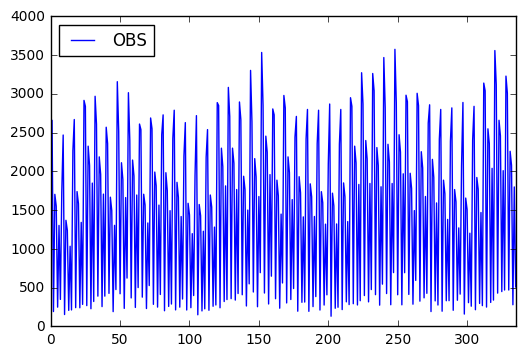

In [44]:
%matplotlib inline

# The magic of pandas control would mean we should be able to trivially throw out 
# plots of things, unstacked and separated out (I don't know how, but I'm told it's easy)

df = conversionsegments[0].topandas()
df.plot()



If you like, proceed to the [reference examples](tutorial_reference.ipynb).